In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import os
from itertools import cycle

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

import optuna

c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pwd = os.getcwd()
pwd

'd:\\Research Projects\\HEA\\Featurize_New_Alloys\\HEA'

In [3]:
df = pd.read_csv(pwd+"/raw_dataset/HEA_tr_NETCORE.csv")
print("Shape of Dataframe: ", df.shape)
df.head()

Shape of Dataframe:  (1167, 44)


,Alloy,avg_dev_AtomicWeight,maximum_MeltingT,avg_dev_MeltingT,mode_MeltingT,avg_dev_Column,mean_Row,mode_Row,minimum_CovalentRadius,maximum_CovalentRadius,range_CovalentRadius,avg_dev_CovalentRadius,mode_CovalentRadius,maximum_Electronegativity,mean_Electronegativity,mode_Electronegativity,mean_NsValence,maximum_NpValence,mean_NpValence,avg_dev_NpValence,range_NdValence,mean_NdValence,avg_dev_NdValence,avg_dev_NValence,mode_NValence,maximum_NdUnfilled,range_NdUnfilled,avg_dev_NdUnfilled,mode_NUnfilled,minimum_GSvolume_pa,range_GSvolume_pa,mode_GSvolume_pa,maximum_GSbandgap,avg_dev_GSbandgap,range_GSmagmom,minimum_SpaceGroupNumber,maximum_SpaceGroupNumber,mean_SpaceGroupNumber,range_Column,maximum_NpUnfilled,maximum_NdValence,mode_MendeleevNumber,range_NUnfilled,Phase
0,Al0.5NbTaTiV,3.838070,3290.0,584.546173,7.571474,0.966843,4.555556,4,121,170,3.912023,2.391138,153,1.63,1.572222,0.916291,1.777778,0.693147,0.111111,0.180262,4,2.666667,0.635989,1.797913,1.609438,8,8,0.908856,7,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,220.777778,9,5,4,43,3,BCC
1,Al0.75MoNbTiV,3.255577,2896.0,521.067701,7.571474,1.140210,4.263158,4,121,164,3.784190,2.377029,153,2.16,1.713158,0.932164,1.578947,0.693147,0.157895,0.235805,5,2.947368,0.845714,0.598806,1.609438,8,8,1.074312,6,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,221.000000,9,5,5,43,3,BCC
2,Al0.25MoNbTiV,3.205911,2896.0,441.662561,7.571474,0.758442,4.411765,4,121,164,3.784190,1.950841,153,2.16,1.725294,0.932164,1.529412,0.693147,0.058824,0.105014,5,3.294118,0.758442,0.492669,1.609438,8,8,0.833360,6,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,220.529412,9,5,5,43,3,BCC
3,Al0.25NbTaTiV,3.825406,3290.0,539.821730,7.571474,0.648931,4.647059,4,121,170,3.912023,2.140270,153,1.63,1.570000,0.916291,1.764706,0.693147,0.058824,0.105014,4,2.823529,0.542163,1.825219,1.609438,8,8,0.718768,7,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,220.529412,9,5,4,43,3,BCC
4,Al0.2MoTaTiV,3.838178,3290.0,565.511565,7.571474,0.703300,4.666667,4,121,170,3.912023,2.105461,153,2.16,1.702857,0.916291,1.761905,0.693147,0.047619,0.086822,5,3.095238,0.645547,1.812332,1.609438,8,8,0.829650,6,2.639771,1.809927,2.639771,0.0,0.0,0.000023,194,229,220.476191,9,5,5,43,3,BCC


In [4]:
# SHUFFLE THE DATASET
df = df.sample(frac=1, random_state=42)
X = df.copy().drop(columns=["Alloy", "Phase"])
y = df["Phase"].astype("category")
print(f"Shape of feature: {X.shape}\nShape of labels: {y.shape}")

Shape of feature: (1167, 42)
Shape of labels: (1167,)


In [5]:
# check class imbalance
print(y.value_counts(ascending=False))

Phase
MIP        428
BCC        363
FCC        211
FCC_BCC    165
Name: count, dtype: int64


In [6]:
from imblearn.over_sampling import SMOTE
X, y = SMOTE(random_state=42).fit_resample(X, y)
print(f"Shape of feature: {X.shape}\nShape of labels: {y.shape}")

c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Shape of feature: (1712, 42)
Shape of labels: (1712,)


In [7]:
# check for class imbalance
print(y.value_counts(ascending=False))

Phase
BCC        428
FCC        428
FCC_BCC    428
MIP        428
Name: count, dtype: int64


In [8]:
# SCALE FEATURES
X = pd.DataFrame(RobustScaler().fit_transform(X), columns=X.columns)
X.head()

,avg_dev_AtomicWeight,maximum_MeltingT,avg_dev_MeltingT,mode_MeltingT,avg_dev_Column,mean_Row,mode_Row,minimum_CovalentRadius,maximum_CovalentRadius,range_CovalentRadius,avg_dev_CovalentRadius,mode_CovalentRadius,maximum_Electronegativity,mean_Electronegativity,mode_Electronegativity,mean_NsValence,maximum_NpValence,mean_NpValence,avg_dev_NpValence,range_NdValence,mean_NdValence,avg_dev_NdValence,avg_dev_NValence,mode_NValence,maximum_NdUnfilled,range_NdUnfilled,avg_dev_NdUnfilled,mode_NUnfilled,minimum_GSvolume_pa,range_GSvolume_pa,mode_GSvolume_pa,maximum_GSbandgap,avg_dev_GSbandgap,range_GSmagmom,minimum_SpaceGroupNumber,maximum_SpaceGroupNumber,mean_SpaceGroupNumber,range_Column,maximum_NpUnfilled,maximum_NdValence,mode_MendeleevNumber,range_NUnfilled
0,0.161097,1.256140,0.606754,0.532601,0.521256,-0.216360,0.0,0.0,0.18,0.584759,0.717467,1.363636,0.25,0.232362,0.449317,-1.196825,0.000000,0.477222,0.422557,0.000000,-0.304043,0.175303,-0.008391,0.000000,0.000000,0.0,0.190333,1.333333,0.000000,0.000000,0.336801,0.000,0.000000,0.0,0.0,0.0,0.640823,0.000000,0.0,0.0,0.000000,0.0
1,-0.709468,-0.647368,-0.538152,-0.471801,-0.863198,0.220453,0.0,1.0,-0.42,-0.427776,-1.279471,0.000000,0.05,1.471545,1.916202,-0.110975,0.584963,-0.223215,-0.254527,-0.666667,1.487024,-0.236945,-0.963679,0.560099,-0.333333,-0.5,-0.196263,-0.333333,0.000000,10.948033,-0.030237,0.000,0.000000,0.0,-53.0,0.0,-0.640578,-0.333333,-0.2,1.0,0.666667,-1.0
2,-0.551801,-0.647368,-0.934202,0.039657,-0.977210,-0.216360,0.0,0.0,-0.70,-0.814217,-1.599888,0.000000,0.00,1.090976,1.916202,1.809577,0.000000,0.026149,0.020301,0.000000,0.584874,-0.225051,-0.802636,0.560099,-0.333333,-0.5,-0.853525,0.000000,0.000000,0.000000,-0.030237,0.000,0.000000,0.0,0.0,0.0,-0.694305,-0.666667,0.0,0.0,0.666667,-1.0
3,0.428073,2.882456,0.969928,-1.266392,0.594814,-1.406341,-1.0,-15.0,-0.42,1.434420,1.058207,-0.272727,0.64,0.850365,0.000000,0.362050,0.584963,1.529725,1.115875,0.000000,-0.534503,0.775456,0.299071,-1.247204,0.000000,0.0,0.262099,0.000000,-79.249736,4.490789,-0.030237,4.496,0.616735,0.0,0.0,0.0,-0.283342,0.333333,0.0,0.0,0.000000,0.0
4,0.071655,1.256140,0.363886,0.039657,0.103571,0.140634,0.0,0.0,0.18,0.584759,0.646848,0.000000,0.25,0.820978,0.449317,-0.535416,0.000000,0.161471,0.153797,0.000000,0.067211,0.047385,-0.120768,0.000000,0.000000,0.0,-0.141745,0.000000,0.000000,0.000000,-0.030237,0.000,0.000000,0.0,0.0,0.0,0.269152,0.000000,0.0,0.0,0.000000,0.0


In [9]:
# Label encode y and then to_categorical
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(y)

In [10]:
labels = list(lb_enc.classes_)
labels

['BCC', 'FCC', 'FCC_BCC', 'MIP']

In [11]:
print(dict(zip(lb_enc.inverse_transform([0, 1, 2, 3]), [0, 1, 2, 3])))

{'BCC': 0, 'FCC': 1, 'FCC_BCC': 2, 'MIP': 3}


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape of training features: {X_train.shape}")
print(f"Shape of training labels: {y_train.shape}")
print(f"Shape of test features: {X_test.shape}")
print(f"Shape of test labels: {y_test.shape}")

Shape of training features: (1369, 42)
Shape of training labels: (1369,)
Shape of test features: (343, 42)
Shape of test labels: (343,)


In [13]:
# DEFINE OBJECTIVE FUNCTION
def obj_fn(trial):
    # DEFINE PARAMETER SPACE
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300, step=50),
        "max_depth":    trial.suggest_int("max_depth", 3, 20),
        "criterion":    trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "min_samples_split":    trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf":     trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"])    
    }
    # CONSTRUCT MODEL
    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)

    return test_acc

In [14]:
# PERFORM BAYESIAN OPTIMIZATION
tpe = optuna.samplers.TPESampler()
study = optuna.create_study(direction="maximize", sampler=tpe)
study.optimize(obj_fn, n_trials=50, show_progress_bar=True)

[I 2024-10-01 04:49:49,848] A new study created in memory with name: no-name-af2fd32e-558f-4220-9d16-63659408e1e8
Best trial: 0. Best value: 0.836735:   2%|▏         | 1/50 [00:03<02:41,  3.29s/it]

[I 2024-10-01 04:49:53,151] Trial 0 finished with value: 0.8367346938775511 and parameters: {'n_estimators': 200, 'max_depth': 9, 'criterion': 'entropy', 'min_samples_split': 18, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8367346938775511.


Best trial: 1. Best value: 0.854227:   4%|▍         | 2/50 [00:06<02:42,  3.39s/it]

[I 2024-10-01 04:49:56,620] Trial 1 finished with value: 0.8542274052478134 and parameters: {'n_estimators': 50, 'max_depth': 11, 'criterion': 'entropy', 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 1 with value: 0.8542274052478134.


Best trial: 1. Best value: 0.854227:   6%|▌         | 3/50 [00:18<05:33,  7.10s/it]

[I 2024-10-01 04:50:08,142] Trial 2 finished with value: 0.8396501457725948 and parameters: {'n_estimators': 300, 'max_depth': 9, 'criterion': 'gini', 'min_samples_split': 4, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 1 with value: 0.8542274052478134.


Best trial: 1. Best value: 0.854227:   8%|▊         | 4/50 [00:21<04:21,  5.68s/it]

[I 2024-10-01 04:50:11,630] Trial 3 finished with value: 0.8338192419825073 and parameters: {'n_estimators': 300, 'max_depth': 12, 'criterion': 'gini', 'min_samples_split': 14, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8542274052478134.


Best trial: 1. Best value: 0.854227:  10%|█         | 5/50 [00:24<03:20,  4.47s/it]

[I 2024-10-01 04:50:13,948] Trial 4 finished with value: 0.8425655976676385 and parameters: {'n_estimators': 150, 'max_depth': 10, 'criterion': 'entropy', 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8542274052478134.


Best trial: 1. Best value: 0.854227:  12%|█▏        | 6/50 [00:25<02:27,  3.35s/it]

[I 2024-10-01 04:50:15,114] Trial 5 finished with value: 0.8338192419825073 and parameters: {'n_estimators': 100, 'max_depth': 20, 'criterion': 'gini', 'min_samples_split': 2, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 1 with value: 0.8542274052478134.


Best trial: 1. Best value: 0.854227:  14%|█▍        | 7/50 [00:37<04:33,  6.36s/it]

[I 2024-10-01 04:50:27,685] Trial 6 finished with value: 0.8309037900874635 and parameters: {'n_estimators': 250, 'max_depth': 7, 'criterion': 'entropy', 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 1 with value: 0.8542274052478134.


Best trial: 1. Best value: 0.854227:  16%|█▌        | 8/50 [00:40<03:35,  5.12s/it]

[I 2024-10-01 04:50:30,154] Trial 7 finished with value: 0.8396501457725948 and parameters: {'n_estimators': 50, 'max_depth': 11, 'criterion': 'gini', 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 0.8542274052478134.


Best trial: 8. Best value: 0.860058:  18%|█▊        | 9/50 [00:45<03:28,  5.08s/it]

[I 2024-10-01 04:50:35,112] Trial 8 finished with value: 0.8600583090379009 and parameters: {'n_estimators': 100, 'max_depth': 10, 'criterion': 'gini', 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 8 with value: 0.8600583090379009.


Best trial: 8. Best value: 0.860058:  20%|██        | 10/50 [01:03<06:03,  9.09s/it]

[I 2024-10-01 04:50:53,217] Trial 9 finished with value: 0.8396501457725948 and parameters: {'n_estimators': 300, 'max_depth': 17, 'criterion': 'entropy', 'min_samples_split': 11, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 8 with value: 0.8600583090379009.


Best trial: 8. Best value: 0.860058:  22%|██▏       | 11/50 [01:04<04:25,  6.81s/it]

[I 2024-10-01 04:50:54,845] Trial 10 finished with value: 0.7055393586005831 and parameters: {'n_estimators': 150, 'max_depth': 3, 'criterion': 'gini', 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 8 with value: 0.8600583090379009.


Best trial: 8. Best value: 0.860058:  24%|██▍       | 12/50 [01:08<03:38,  5.74s/it]

[I 2024-10-01 04:50:58,156] Trial 11 finished with value: 0.8513119533527697 and parameters: {'n_estimators': 50, 'max_depth': 14, 'criterion': 'entropy', 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 8 with value: 0.8600583090379009.


Best trial: 8. Best value: 0.860058:  26%|██▌       | 13/50 [01:11<03:07,  5.06s/it]

[I 2024-10-01 04:51:01,666] Trial 12 finished with value: 0.8425655976676385 and parameters: {'n_estimators': 100, 'max_depth': 6, 'criterion': 'gini', 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 8 with value: 0.8600583090379009.


Best trial: 8. Best value: 0.860058:  28%|██▊       | 14/50 [01:18<03:25,  5.70s/it]

[I 2024-10-01 04:51:08,843] Trial 13 finished with value: 0.8600583090379009 and parameters: {'n_estimators': 100, 'max_depth': 14, 'criterion': 'entropy', 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 8 with value: 0.8600583090379009.


Best trial: 8. Best value: 0.860058:  30%|███       | 15/50 [01:20<02:35,  4.44s/it]

[I 2024-10-01 04:51:10,355] Trial 14 finished with value: 0.8483965014577259 and parameters: {'n_estimators': 100, 'max_depth': 15, 'criterion': 'gini', 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 8 with value: 0.8600583090379009.


Best trial: 8. Best value: 0.860058:  32%|███▏      | 16/50 [01:33<03:57,  6.99s/it]

[I 2024-10-01 04:51:23,258] Trial 15 finished with value: 0.8454810495626822 and parameters: {'n_estimators': 200, 'max_depth': 14, 'criterion': 'entropy', 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 8 with value: 0.8600583090379009.


Best trial: 16. Best value: 0.862974:  34%|███▍      | 17/50 [01:40<03:54,  7.10s/it]

[I 2024-10-01 04:51:30,599] Trial 16 finished with value: 0.8629737609329446 and parameters: {'n_estimators': 150, 'max_depth': 17, 'criterion': 'gini', 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  36%|███▌      | 18/50 [01:47<03:45,  7.04s/it]

[I 2024-10-01 04:51:37,508] Trial 17 finished with value: 0.8629737609329446 and parameters: {'n_estimators': 150, 'max_depth': 20, 'criterion': 'gini', 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  38%|███▊      | 19/50 [01:49<02:50,  5.51s/it]

[I 2024-10-01 04:51:39,459] Trial 18 finished with value: 0.8396501457725948 and parameters: {'n_estimators': 200, 'max_depth': 20, 'criterion': 'gini', 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  40%|████      | 20/50 [01:51<02:11,  4.40s/it]

[I 2024-10-01 04:51:41,265] Trial 19 finished with value: 0.8425655976676385 and parameters: {'n_estimators': 150, 'max_depth': 18, 'criterion': 'gini', 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  42%|████▏     | 21/50 [02:02<03:02,  6.29s/it]

[I 2024-10-01 04:51:51,974] Trial 20 finished with value: 0.8454810495626822 and parameters: {'n_estimators': 250, 'max_depth': 17, 'criterion': 'gini', 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  44%|████▍     | 22/50 [02:08<02:58,  6.36s/it]

[I 2024-10-01 04:51:58,458] Trial 21 finished with value: 0.8629737609329446 and parameters: {'n_estimators': 150, 'max_depth': 18, 'criterion': 'gini', 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  46%|████▌     | 23/50 [02:15<02:56,  6.55s/it]

[I 2024-10-01 04:52:05,477] Trial 22 finished with value: 0.8629737609329446 and parameters: {'n_estimators': 150, 'max_depth': 18, 'criterion': 'gini', 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  48%|████▊     | 24/50 [02:22<02:49,  6.51s/it]

[I 2024-10-01 04:52:11,897] Trial 23 finished with value: 0.8454810495626822 and parameters: {'n_estimators': 150, 'max_depth': 19, 'criterion': 'gini', 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  50%|█████     | 25/50 [02:31<03:01,  7.25s/it]

[I 2024-10-01 04:52:20,855] Trial 24 finished with value: 0.8483965014577259 and parameters: {'n_estimators': 200, 'max_depth': 16, 'criterion': 'gini', 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  52%|█████▏    | 26/50 [02:41<03:18,  8.28s/it]

[I 2024-10-01 04:52:31,561] Trial 25 finished with value: 0.8513119533527697 and parameters: {'n_estimators': 250, 'max_depth': 20, 'criterion': 'gini', 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  54%|█████▍    | 27/50 [02:47<02:55,  7.64s/it]

[I 2024-10-01 04:52:37,702] Trial 26 finished with value: 0.8483965014577259 and parameters: {'n_estimators': 150, 'max_depth': 18, 'criterion': 'gini', 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  56%|█████▌    | 28/50 [02:58<03:05,  8.43s/it]

[I 2024-10-01 04:52:47,965] Trial 27 finished with value: 0.8542274052478134 and parameters: {'n_estimators': 200, 'max_depth': 16, 'criterion': 'gini', 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  58%|█████▊    | 29/50 [02:59<02:11,  6.26s/it]

[I 2024-10-01 04:52:49,167] Trial 28 finished with value: 0.8425655976676385 and parameters: {'n_estimators': 100, 'max_depth': 16, 'criterion': 'gini', 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  60%|██████    | 30/50 [03:00<01:36,  4.84s/it]

[I 2024-10-01 04:52:50,700] Trial 29 finished with value: 0.8454810495626822 and parameters: {'n_estimators': 150, 'max_depth': 19, 'criterion': 'gini', 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  62%|██████▏   | 31/50 [03:03<01:17,  4.07s/it]

[I 2024-10-01 04:52:52,985] Trial 30 finished with value: 0.8075801749271136 and parameters: {'n_estimators': 200, 'max_depth': 13, 'criterion': 'gini', 'min_samples_split': 13, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  64%|██████▍   | 32/50 [03:10<01:30,  5.01s/it]

[I 2024-10-01 04:53:00,194] Trial 31 finished with value: 0.8629737609329446 and parameters: {'n_estimators': 150, 'max_depth': 18, 'criterion': 'gini', 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  66%|██████▌   | 33/50 [03:17<01:35,  5.62s/it]

[I 2024-10-01 04:53:07,246] Trial 32 finished with value: 0.8454810495626822 and parameters: {'n_estimators': 150, 'max_depth': 19, 'criterion': 'gini', 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  68%|██████▊   | 34/50 [03:23<01:34,  5.91s/it]

[I 2024-10-01 04:53:13,817] Trial 33 finished with value: 0.8600583090379009 and parameters: {'n_estimators': 150, 'max_depth': 17, 'criterion': 'gini', 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  70%|███████   | 35/50 [03:32<01:39,  6.60s/it]

[I 2024-10-01 04:53:22,036] Trial 34 finished with value: 0.8483965014577259 and parameters: {'n_estimators': 200, 'max_depth': 18, 'criterion': 'gini', 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  72%|███████▏  | 36/50 [03:36<01:21,  5.86s/it]

[I 2024-10-01 04:53:26,136] Trial 35 finished with value: 0.8454810495626822 and parameters: {'n_estimators': 100, 'max_depth': 20, 'criterion': 'gini', 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  74%|███████▍  | 37/50 [03:41<01:14,  5.74s/it]

[I 2024-10-01 04:53:31,615] Trial 36 finished with value: 0.8454810495626822 and parameters: {'n_estimators': 150, 'max_depth': 15, 'criterion': 'gini', 'min_samples_split': 17, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  76%|███████▌  | 38/50 [03:44<00:57,  4.81s/it]

[I 2024-10-01 04:53:34,253] Trial 37 finished with value: 0.8571428571428571 and parameters: {'n_estimators': 200, 'max_depth': 19, 'criterion': 'gini', 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  78%|███████▊  | 39/50 [03:50<00:57,  5.24s/it]

[I 2024-10-01 04:53:40,508] Trial 38 finished with value: 0.8513119533527697 and parameters: {'n_estimators': 100, 'max_depth': 17, 'criterion': 'entropy', 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  80%|████████  | 40/50 [03:59<01:01,  6.20s/it]

[I 2024-10-01 04:53:48,924] Trial 39 finished with value: 0.8425655976676385 and parameters: {'n_estimators': 250, 'max_depth': 12, 'criterion': 'gini', 'min_samples_split': 20, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  82%|████████▏ | 41/50 [04:00<00:43,  4.84s/it]

[I 2024-10-01 04:53:50,621] Trial 40 finished with value: 0.8367346938775511 and parameters: {'n_estimators': 50, 'max_depth': 15, 'criterion': 'gini', 'min_samples_split': 14, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  84%|████████▍ | 42/50 [04:07<00:42,  5.34s/it]

[I 2024-10-01 04:53:57,099] Trial 41 finished with value: 0.8629737609329446 and parameters: {'n_estimators': 150, 'max_depth': 18, 'criterion': 'gini', 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  86%|████████▌ | 43/50 [04:13<00:40,  5.73s/it]

[I 2024-10-01 04:54:03,735] Trial 42 finished with value: 0.8513119533527697 and parameters: {'n_estimators': 150, 'max_depth': 19, 'criterion': 'gini', 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  88%|████████▊ | 44/50 [04:20<00:35,  5.97s/it]

[I 2024-10-01 04:54:10,271] Trial 43 finished with value: 0.8542274052478134 and parameters: {'n_estimators': 150, 'max_depth': 20, 'criterion': 'gini', 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  90%|█████████ | 45/50 [04:27<00:32,  6.40s/it]

[I 2024-10-01 04:54:17,678] Trial 44 finished with value: 0.8600583090379009 and parameters: {'n_estimators': 150, 'max_depth': 18, 'criterion': 'gini', 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  92%|█████████▏| 46/50 [04:29<00:20,  5.06s/it]

[I 2024-10-01 04:54:19,636] Trial 45 finished with value: 0.8542274052478134 and parameters: {'n_estimators': 100, 'max_depth': 17, 'criterion': 'entropy', 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  94%|█████████▍| 47/50 [04:35<00:15,  5.17s/it]

[I 2024-10-01 04:54:25,067] Trial 46 finished with value: 0.8542274052478134 and parameters: {'n_estimators': 150, 'max_depth': 7, 'criterion': 'gini', 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  96%|█████████▌| 48/50 [04:39<00:09,  4.87s/it]

[I 2024-10-01 04:54:29,220] Trial 47 finished with value: 0.8513119533527697 and parameters: {'n_estimators': 100, 'max_depth': 16, 'criterion': 'gini', 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974:  98%|█████████▊| 49/50 [04:54<00:07,  7.89s/it]

[I 2024-10-01 04:54:44,164] Trial 48 finished with value: 0.8483965014577259 and parameters: {'n_estimators': 200, 'max_depth': 10, 'criterion': 'entropy', 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 16 with value: 0.8629737609329446.


Best trial: 16. Best value: 0.862974: 100%|██████████| 50/50 [04:56<00:00,  5.92s/it]

[I 2024-10-01 04:54:45,939] Trial 49 finished with value: 0.8483965014577259 and parameters: {'n_estimators': 150, 'max_depth': 19, 'criterion': 'gini', 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.8629737609329446.


In [15]:
best_model_params = study.best_params
best_model_params

{'n_estimators': 150,
 'max_depth': 17,
 'criterion': 'gini',
 'min_samples_split': 17,
 'min_samples_leaf': 3,
 'max_features': None}

In [16]:
# BUILD MODEL USING BEST PARAMETERS AND EVALUATE
best_model = RandomForestClassifier(**best_model_params, random_state=42)
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# CLASSIFICATION REPORT
print("Classification Report on Training Data")
print("-"*80)
print(classification_report(y_train, y_train_pred, target_names=labels, digits=4))

print("Classification Report on Test Data")
print("-"*80)
print(classification_report(y_test, y_test_pred, target_names=labels, digits=4))

# EVALUATE ROC-AUC SCORE
pred_proba = best_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, pred_proba, multi_class='ovr')
print("-"*80)
print(f"ROC-AUC SCORE: {roc_auc*100: .4f} %")

Classification Report on Training Data
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         BCC     0.9114    0.9062    0.9088       352
         FCC     0.9424    0.9228    0.9325       337
     FCC_BCC     0.8992    0.9677    0.9322       341
         MIP     0.9068    0.8614    0.8835       339

    accuracy                         0.9145      1369
   macro avg     0.9150    0.9145    0.9143      1369
weighted avg     0.9149    0.9145    0.9142      1369

Classification Report on Test Data
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         BCC     0.9041    0.8684    0.8859        76
         FCC     0.8966    0.8571    0.8764        91
     FCC_BCC     0.8137    0.9540    0.8783        87
         MIP     0.8519    0.7753    0.8118        89

    accuracy                         0.8630       343
   

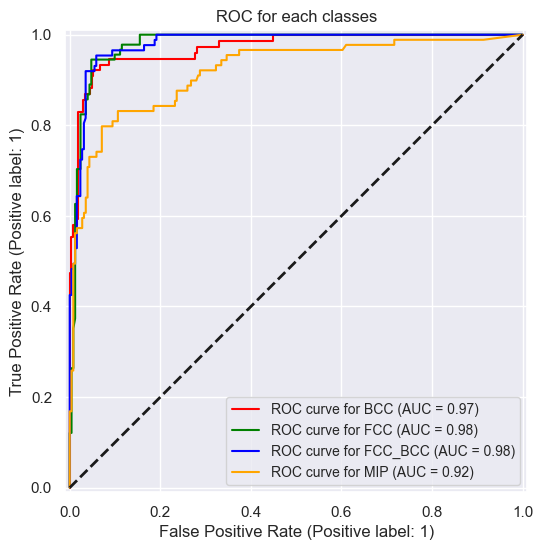

In [17]:
# PLOT ROC CURVE
fig, ax = plt.subplots(figsize=(6, 6))
y_test_oh = to_categorical(y_test)
colors = cycle(["red", "green", "blue", "orange"])
for class_id, color in zip(range(4), colors):
    RocCurveDisplay.from_predictions(
        y_test_oh[:, class_id],
        pred_proba[:, class_id],
        name=f"ROC curve for {labels[class_id]}",
        color=color,
        ax=ax,
    )
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.legend(loc='lower right', fontsize='10')
plt.title("ROC for each classes")
plt.savefig(pwd+"/figures/rf_roc_curve.png", dpi=600, bbox_inches="tight")

Training accuracy per class: [0.90625    0.92284866 0.96774194 0.86135693]
Testing accuracy per class: [0.86842105 0.85714286 0.95402299 0.7752809 ]


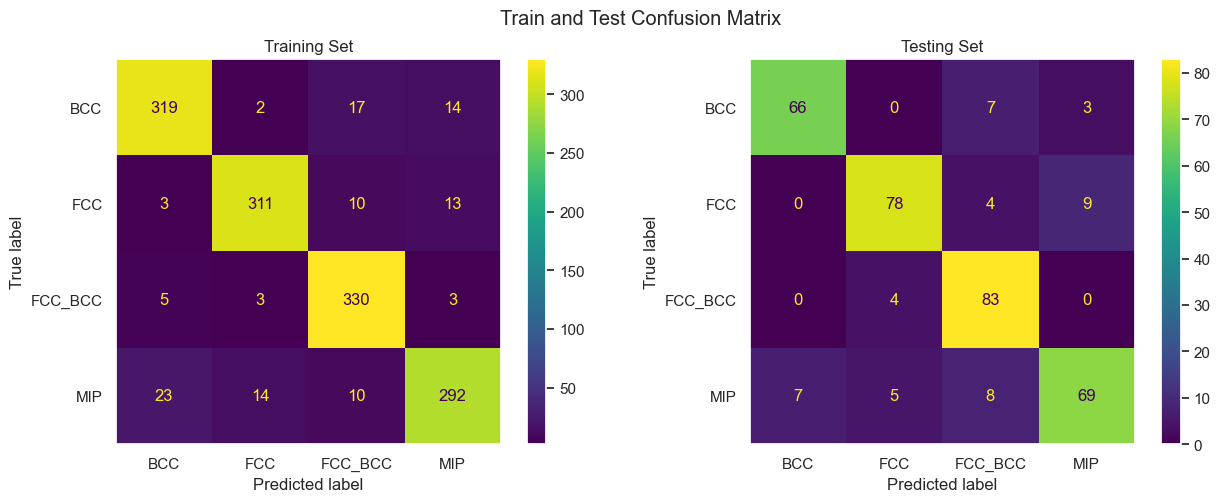

In [18]:
# CONFUSION MATRIX
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
f,(ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
disp_train.plot(ax = ax1)
disp_test.plot(ax = ax2)
ax1.set_title('Training Set')
ax2.set_title('Testing Set')
ax1.grid(False)
ax2.grid(False)
plt.suptitle('Train and Test Confusion Matrix')
plt.savefig(pwd+"/figures/rf_cf.png", dpi=600, bbox_inches="tight")
# ACCURACY PER CLASS
acc_class_train = cm_train.diagonal() / cm_train.sum(axis=1)
acc_class_test = cm_test.diagonal() / cm_test.sum(axis=1)

print("Training accuracy per class:", acc_class_train)
print("Testing accuracy per class:", acc_class_test)

In [19]:
# 10 FOLD CROSS VALIDATION
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []

for train_idx, test_idx in kfold.split(X, y):
    X_train_cv, y_train_cv = X.iloc[train_idx], y[train_idx]
    X_test_cv, y_test_cv = X.iloc[test_idx], y[test_idx]
    best_model.fit(X_train_cv, y_train_cv)
    y_test_pred_cv = best_model.predict(X_test_cv)
    score = accuracy_score(y_test_cv, y_test_pred_cv)
    cv_scores.append(score*100)

print("Cross Validation Score")
print("-"*50)
print(f"Mean Accuracy: {np.mean(cv_scores): .4f} % \nStandard Deviation: (+/-){np.std(cv_scores): .4f} %")
print("-"*50)

Cross Validation Score
--------------------------------------------------
Mean Accuracy:  84.3418 % 
Standard Deviation: (+/-) 2.7076 %
--------------------------------------------------
